In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, DateFormatter
from datetime import datetime
import seaborn as sns
import numpy as np
import warnings
# from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.stats import linregress, pearsonr, ttest_ind
# This will suppress all warnings
warnings.simplefilter(action='ignore', category=Warning)

## HRV plot

#### read hr-hrv file

In [2]:
df_hrhrv = pd.read_csv("/Users/yiwengeng/Documents/Oura_test/PTL02_hr-hrv.csv")
temp = list(df_hrhrv["timestamp"])
z = {}
for i in range(len(temp)):
    z[i] = temp[i][0:19]
#     date[i] = datetime.strptime(z[i], '%Y-%m-%dT%H:%M:%S')

date = pd.DataFrame({'date': z})
date['date'] = pd.to_datetime(date['date'], format='%Y-%m-%dT%H:%M:%S')


### eliminate all NaN data

In [3]:
# select data from 12AM-6AM and HRV is not 0
df = pd.DataFrame({"Date":date['date'],"HRV":df_hrhrv["5-min hrv"] })
filtered_df = df[df['Date'].dt.time <= pd.Timestamp("06:00:00").time()]
filtered_df = filtered_df.loc[filtered_df['HRV'] != 0]

### Calculate average HRV by hour

In [8]:
# Resample the data to get the hourly average
hourly_average = filtered_df.resample('H', on='Date').mean()

# Reset the index to have the Date column and rename columns
## Define the Hourly data
hourly_average.reset_index(inplace=True)
hourly_average.columns = ['Date', 'HRV']
Hourly = hourly_average.dropna()
Hourly.loc[:, "idx"] = np.linspace(1,len(Hourly),len(Hourly))
Hourly.loc[:, 'Date'] = Hourly['Date'].dt.strftime('%Y-%m-%d-%H')
Hourly["HRV_z"] = (Hourly["HRV"]-Hourly["HRV"].mean()) / Hourly["HRV"].std()
Hourly["Simple_Avg"] = Hourly["HRV"].rolling(window=5,min_periods=4).mean()
Hourly["EM_Avg"] = Hourly["HRV"].ewm(span=5).mean()
Hourly["EM_new"] = Hourly["HRV"].ewm(span=3).mean()
Hourly["color"], unique = pd.factorize(Hourly["Date"].dt.date)

# hrv daily average
HRV_Daily = Hourly.groupby(Hourly['Date'].dt.date)['HRV'].mean().reset_index()
HRV_Daily["hrv_EM"] = HRV_Daily["HRV"].ewm(span=3).mean()

[Text(0, 0.0, '0.0'),
 Text(0, 10.0, '10.0'),
 Text(0, 20.0, '20.0'),
 Text(0, 30.0, '30.0'),
 Text(0, 40.0, '40.0'),
 Text(0, 50.0, '50.0'),
 Text(0, 60.0, '60.0')]

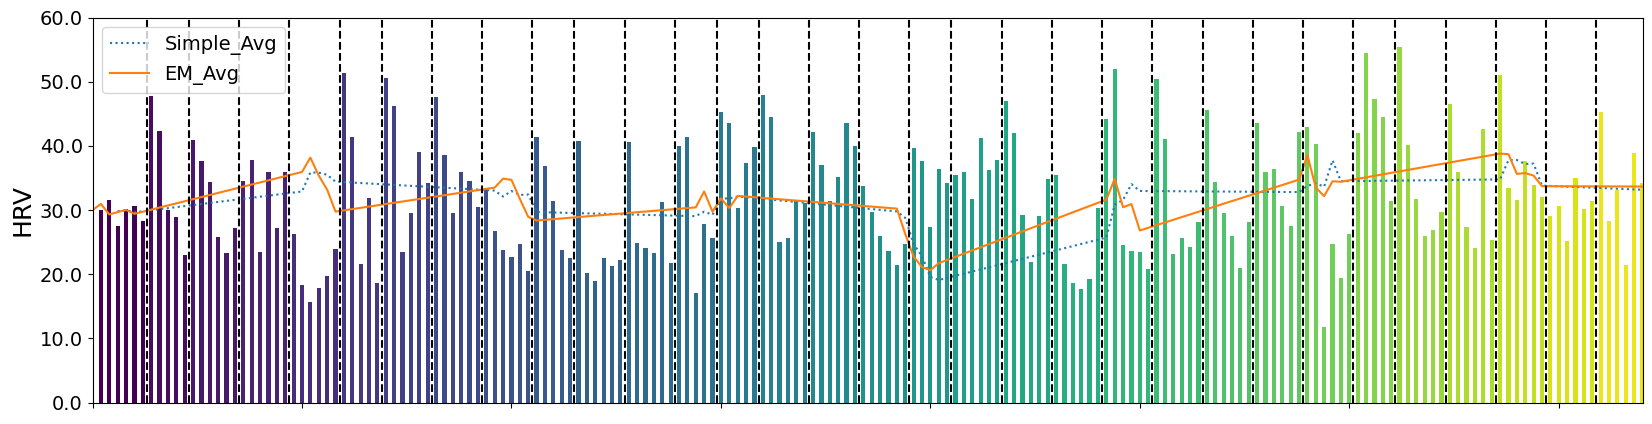

In [5]:
colormap = plt.cm.viridis  # You can change viridis to another colormap like 'plasma', 'magma', etc.
norm = plt.Normalize(vmin=0, vmax=len(unique))
color_map = {i: colormap(norm(i)) for i in range(len(unique))}
bar_colors = Hourly['color'].map(color_map)
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(Hourly["idx"], Hourly["HRV"],color=bar_colors,width = 0.5)
L1, = ax.plot(Hourly["Simple_Avg"], color = "tab:blue", linestyle=":")
L2, = ax.plot(Hourly["EM_Avg"], color = "tab:orange")

for i in range(1, len(Hourly)):
    if Hourly['color'].iloc[i] != Hourly['color'].iloc[i-1]:
        ax.axvline(x=Hourly['idx'].iloc[i] - 0.5, color='black', linestyle='--') 

ax.legend([L1,L2], ['Simple_Avg', 'EM_Avg'],fontsize=14)
# ax.grid()
ax.set_xlim(0,len(Hourly))

ax.set_ylim(0,60)
ax.set_ylabel('HRV',fontsize=18)
ax.set_xticklabels([])
ax.set_yticklabels(ax.get_yticks(), fontsize=14)

### (Not executed) all data plot

In [ ]:
filtered_df = filtered_df.dropna()
filtered_df.loc[:, "idx"] = np.linspace(1,len(filtered_df),len(filtered_df))
filtered_df["Simple_Avg"] = filtered_df["HRV"].rolling(window=4).mean()
filtered_df["EM_Avg"] = filtered_df["HRV"].ewm(span=4).mean()


fig, ax = plt.subplots(figsize=(20,5))
ax.bar(filtered_df["idx"], filtered_df["HRV"],width = 0.5, alpha=0.5)
ax.plot(Hourly["Simple_Avg"], color = "tab:blue")
ax.plot(filtered_df["EM_Avg"], color = "tab:orange")
# ax.grid()
ax.set_xlim(0,185)

ax.set_ylim(0,60)
ax.set_ylabel('HRV',fontsize=18)
# ax.set_xticklabels([])
ax.set_yticklabels(ax.get_yticks(), fontsize=14)

## Activity

### Load activity data

In [5]:
df_act = pd.read_csv("/Users/yiwengeng/Documents/PregnantPrj/Data/PTL_Data/PTL02/PTL02_activity.csv", parse_dates = [0])
df_act.rename(columns={'score':'ActS'},inplace=True)
df_act.loc[:, "idx"] = np.linspace(1,len(df_act),len(df_act))
df_act["steps_z"] = (df_act["steps"] - df_act["steps"].mean()) / df_act["steps"].std()
# df_act["Simple_Avg"] = df_act["steps"].rolling(window=3).mean()
df_act["steps_EM"] = df_act["steps"].ewm(span=3).mean()
# df_act["EM_new"] = Hourly["HRV"].ewm(span=3).mean()

## Sleep

In [6]:
df_sleep = pd.read_csv("/Users/yiwengeng/Documents/PregnantPrj/Data/PTL_Data/PTL02/PTL02_sleep.csv", parse_dates = [0])
df_sleep.rename(columns={'score':'SleepS'},inplace=True)
df_sleep.loc[:, "idx"] = np.linspace(1,len(df_sleep),len(df_sleep))
df_sleep["rmssd_z"] = (df_sleep["rmssd"] - df_sleep["rmssd"].mean()) / df_sleep["rmssd"].std()
df_sleep["rmssd_EM"] = df_sleep["rmssd"].ewm(span=3).mean()
df_sleep["score_rem_z"] = (df_sleep["score_rem"] - df_sleep["score_rem"].mean()) / df_sleep["rmssd"].std()
df_sleep["rem_EM"] = df_sleep["score_rem"].ewm(span=3).mean()


In [16]:
df1 = pd.DataFrame([2, 3, 4, 5, 6], columns=['value'])
df2 = pd.DataFrame([10, 14, 16, 18, 20], columns=['value'])

# Calculate Pearson correlation and p-value
correlation_coefficient, p_value_corr = pearsonr(df1['value'], df2['value'])
correlation_coefficient, p_value_corr
df3 = df2.shift(-2)
correlation_coefficient, p_value_corr = pearsonr(df1['value'], df3['value'])
correlation_coefficient, p_value_corr


ValueError: array must not contain infs or NaNs

In [ ]:
def corr_lagged(df1, df2, max_lag):
    result = {}

    for lag in range(max_lag+1):
        shifted = df2.shift(-lag)
        


def rolling_corr_lagged(df, col1, col2, window, max_lag):    
    # Container to store results
    result = pd.DataFrame(index=df.index)
    
    for lag in range(max_lag + 1):
        shifted = df[col2].shift(-lag)  # negative lag means col2 is shifted up
        correlation = df[col1].rolling(window=window).corr(shifted)
        result[lag] = correlation
    return result

In [84]:
# 要计算pearson的HRV_daily & steps
pearson = pd.concat([HRV_Daily,df_act["steps"]],axis=1)
pearson["HRV_z"] = (pearson["HRV"] - pearson["HRV"].mean()) / pearson["HRV"].std()
pearson["steps_z"] = (pearson["steps"] - pearson["steps"].mean()) / pearson["steps"].std()


MT | slope: nan, intercept: nan, r_value: nan, p_value: nan


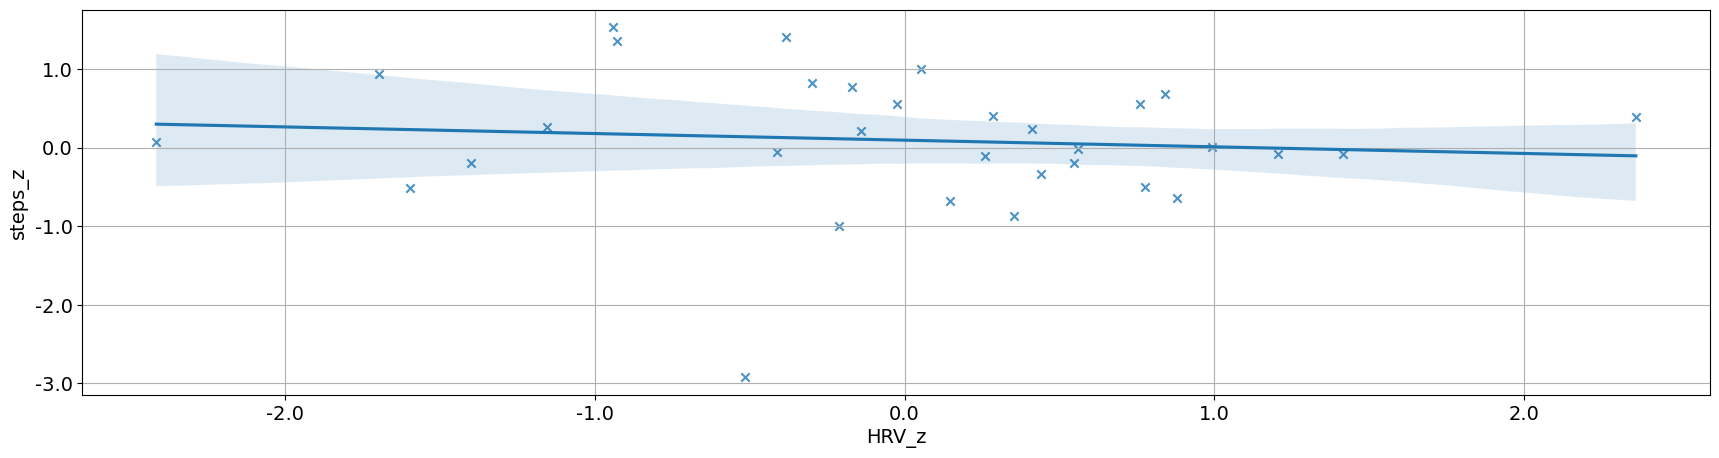

In [85]:
fig,ax1 = plt.subplots(figsize=(21, 5))
sns.regplot(x='HRV_z', y='steps_z', data=pearson, marker='x', color= "tab:blue",ax = ax1)

ax1.grid(True)
ax1.set_xlabel("HRV_z",fontsize=14)
ax1.set_ylabel('steps_z',fontsize=14)
ax1.set_xticklabels(ax1.get_xticks(), fontsize=14)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=14)


# plt.plot( X, LinearRegression().fit(X, Y).predict(X) )
slope, intercept, r_value, p_value, _ = linregress(pearson["steps_z"],pearson["HRV_z"])
print(f"MT | slope: {slope:.4f}, intercept: {intercept:.4f}, r_value: {r_value:.4f}, p_value: {p_value:.4f}")


[Text(0, 0.0, '0.0'),
 Text(0, 5.0, '5.0'),
 Text(0, 10.0, '10.0'),
 Text(0, 15.0, '15.0'),
 Text(0, 20.0, '20.0'),
 Text(0, 25.0, '25.0'),
 Text(0, 30.0, '30.0'),
 Text(0, 35.0, '35.0'),
 Text(0, 40.0, '40.0'),
 Text(0, 45.0, '45.0')]

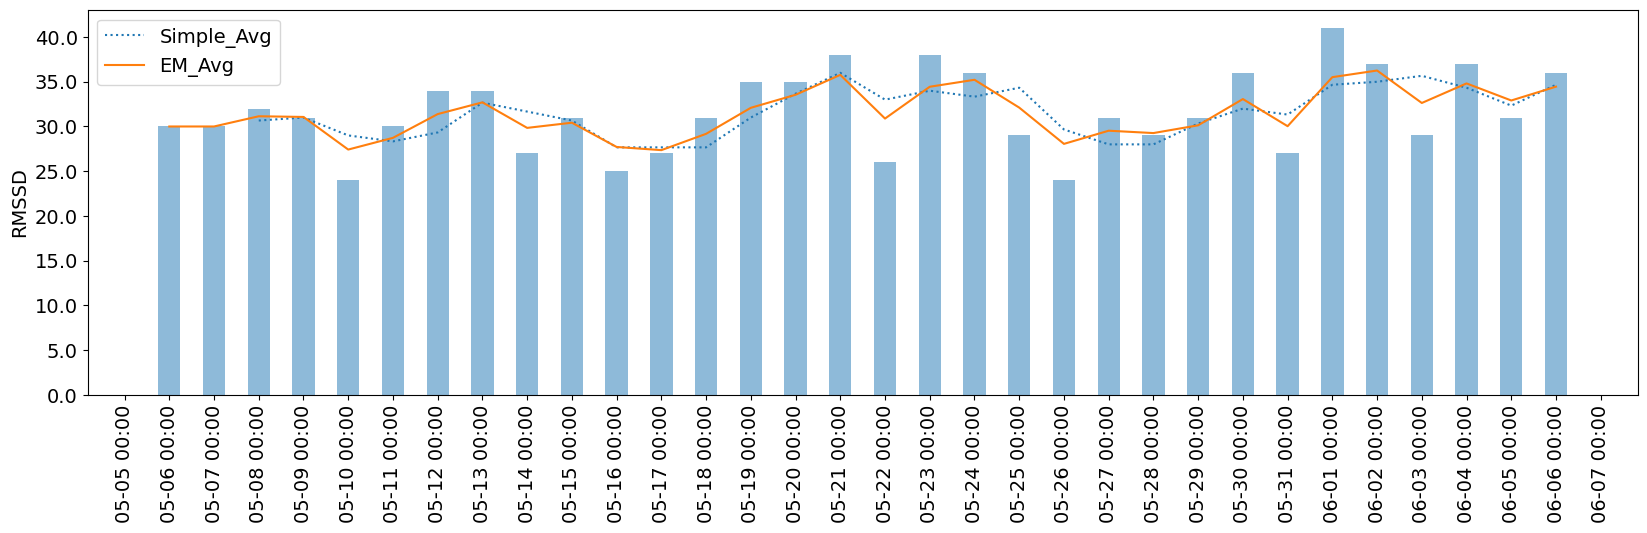

In [71]:
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(df_sleep["summary_date"], df_sleep["rmssd"],width = 0.5, alpha = 0.5)
L1, = ax.plot(df_sleep["summary_date"],df_sleep["Simple_Avg"], color = "tab:blue", linestyle=":")
L2, = ax.plot(df_sleep["summary_date"], df_sleep["EM_Avg"], color = "tab:orange")
ax.legend([L1,L2], ['Simple_Avg', 'EM_Avg'],fontsize=14)
# ax.grid()
# # ax.set_xlim(0,len(df_sleep))
# ax.set_ylim(0,100)
ax.set_ylabel('RMSSD',fontsize=14)
ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
ax.xaxis.set_major_locator(AutoDateLocator(maxticks=50))
plt.xticks(rotation = 90, ha = 'center',fontsize=14)
# ax.set_xticklabels(ax.get_yticks(), fontsize=14)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)

[Text(0, 0.0, '0.0'),
 Text(0, 2000.0, '2000.0'),
 Text(0, 4000.0, '4000.0'),
 Text(0, 6000.0, '6000.0'),
 Text(0, 8000.0, '8000.0'),
 Text(0, 10000.0, '10000.0'),
 Text(0, 12000.0, '12000.0'),
 Text(0, 14000.0, '14000.0')]

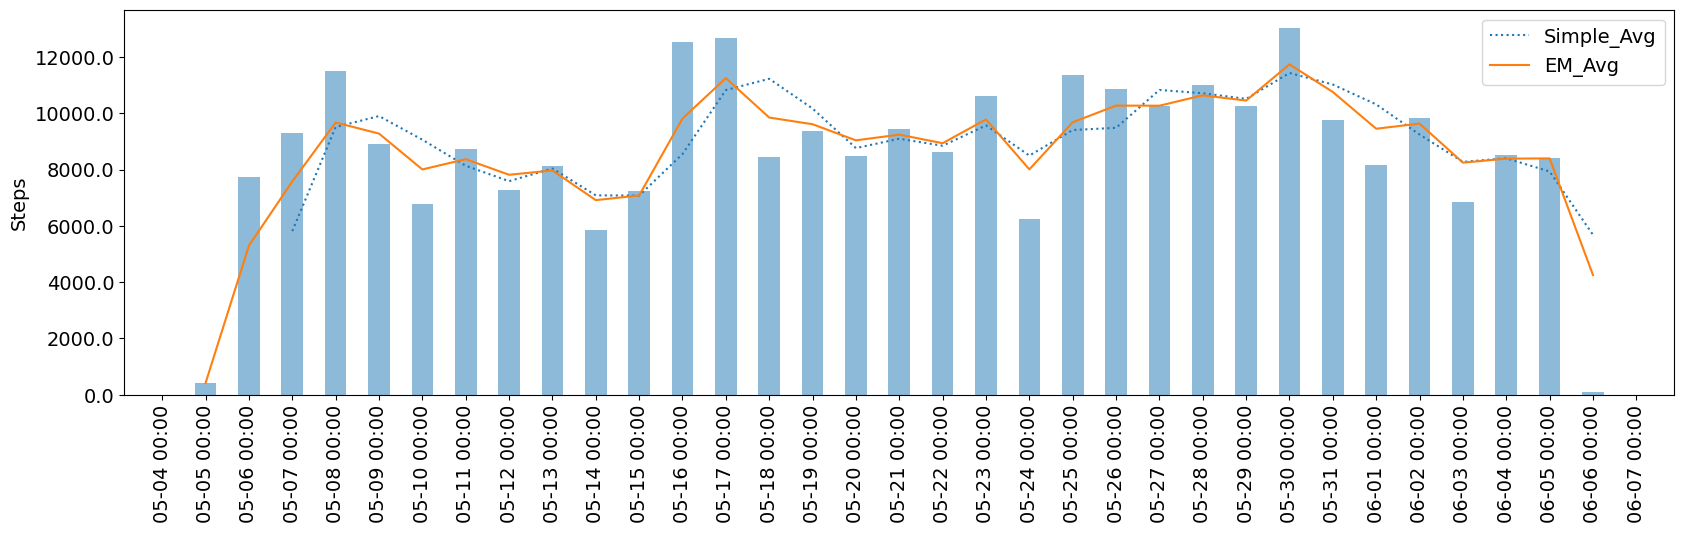

In [62]:
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(df_act["summary_date"], df_act["steps"],width = 0.5, alpha = 0.5)
L1, = ax.plot(df_act["summary_date"],df_act["Simple_Avg"], color = "tab:blue", linestyle=":")
L2, = ax.plot(df_act["summary_date"], df_act["EM_Avg"], color = "tab:orange")
ax.legend([L1,L2], ['Simple_Avg', 'EM_Avg'],fontsize=14)
# ax.grid()
# # ax.set_xlim(0,len(df_act))
# ax.set_ylim(0,100)
ax.set_ylabel('Steps',fontsize=14)
ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
ax.xaxis.set_major_locator(AutoDateLocator(maxticks=50))
plt.xticks(rotation = 90, ha = 'center',fontsize=14)
# ax.set_xticklabels(ax.get_yticks(), fontsize=14)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)

In [46]:
a =  pd.read_csv("/Users/yiwengeng/Documents/PregnantPrj/Data/hrv.csv")
a.rename(columns={"Y": "HRV_z"},inplace=True)


In [44]:
print(corrs.argmax(),corrs.argmin())
print(corrs.max(),corrs.min())

9 16
6.478391624828428 -10.464839731855951


In [23]:
Hourly.to_csv("/Users/yiwengeng/Documents/PregnantPrj/Data/Hourly.csv")

In [27]:
a = Hourly["HRV_z"][0:5]
b = df_act["ActS_z"][0:3]
corrs = np.correlate(a,b,'full')
print(a,b,corrs)

0   -0.239002
1   -0.061168
2   -0.519793
3   -0.220283
4   -0.173485
Name: HRV_z, dtype: float64 0    1.913188
1    1.579140
2    1.356441
Name: ActS_z, dtype: float64 [-0.3241926  -0.46038934 -1.25891861 -1.23665347 -1.57764177 -0.6953994
 -0.33190871]


#### Rolling Correlation at Differenc Lags

In [66]:
def rolling_corr_lagged(df, col1, col2, window, max_lag):    
    # Container to store results
    result = pd.DataFrame(index=df.index)
    
    for lag in range(max_lag + 1):
        shifted = df[col2].shift(-lag)  # negative lag means col2 is shifted up
        correlation = df[col1].rolling(window=window).corr(shifted)
        result[lag] = correlation
    return result


In [72]:
window = 7
max_lag = 5
correlations = rolling_corr_lagged(a,"HRV_z","Act_z", window,max_lag)

fig,ax = plt.subplots(figsize=(12,6))
for lag, corr in correlations.items():
    ax.plot(corr.index, corr, label=f"Lag {lag}")
ax.legend()
plt.title("Rolling Correlation at Differenc Lags")



KeyError: 'Act_z'

In [73]:
Hourly.head(10)

,Date,HRV,idx,HRV_z,Simple_Avg,EM_Avg,EM_new,color
0,2023-05-06 00:00:00,30.000000,1.0,-0.239002,NaN,30.000000,30.000000,0
1,2023-05-06 01:00:00,31.583333,2.0,-0.061168,NaN,30.950000,31.055556,0
2,2023-05-06 02:00:00,27.500000,3.0,-0.519793,NaN,29.315789,29.023810,0
3,2023-05-06 03:00:00,30.166667,4.0,-0.220283,29.812500,29.669231,29.633333,0
4,2023-05-06 04:00:00,30.583333,5.0,-0.173485,29.966667,30.020142,30.123656,0
5,2023-05-06 05:00:00,28.333333,6.0,-0.426196,29.633333,29.403759,29.214286,0
25,2023-05-07 01:00:00,47.833333,7.0,1.763972,32.883333,35.928849,38.597113,1
26,2023-05-07 02:00:00,42.363636,8.0,1.149636,35.856061,38.160868,40.487760,1
27,2023-05-07 03:00:00,30.000000,9.0,-0.239002,35.822727,35.367928,35.233618,1
28,2023-05-07 04:00:00,28.916667,10.0,-0.360678,35.489394,33.179558,32.072055,1
